# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

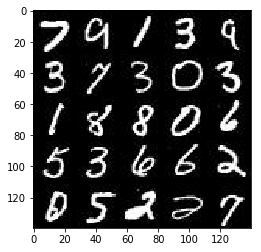

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

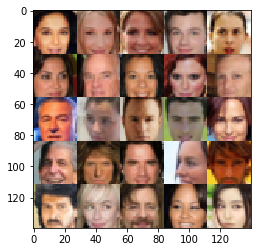

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu1, 256, 5, strides=1, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*x3, x3)
        # 7x7x256
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
    
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    losses = []
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                if steps % 10 == 0 or steps == 1:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    # losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0 or steps == 1:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        print("Done");
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6305... Generator Loss: 0.3340


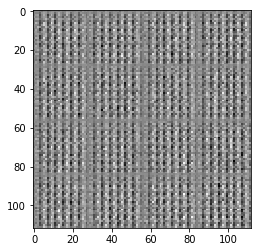

Epoch 1/2... Discriminator Loss: 0.6492... Generator Loss: 1.3629
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.8756
Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.7711
Epoch 1/2... Discriminator Loss: 1.2043... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 0.8029
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.2921... Generator Loss: 0.6628
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.7123
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 0.8097


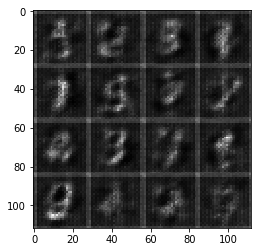

Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 1.0151
Epoch 1/2... Discriminator Loss: 1.2921... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.8121
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 1.0980
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 1.1712
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.9641
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 0.9895
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.8204
Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 0.8915


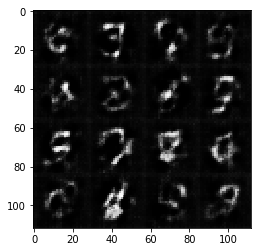

Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 0.7353
Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 0.9855
Epoch 1/2... Discriminator Loss: 1.1760... Generator Loss: 1.0988
Epoch 1/2... Discriminator Loss: 1.1672... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 1.0966... Generator Loss: 0.8827
Epoch 1/2... Discriminator Loss: 1.2031... Generator Loss: 1.3191
Epoch 1/2... Discriminator Loss: 1.0926... Generator Loss: 0.8672
Epoch 1/2... Discriminator Loss: 1.0810... Generator Loss: 1.0582
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 0.8763


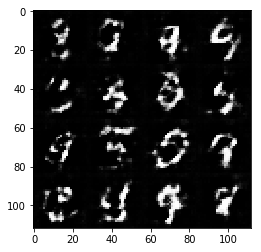

Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 1.0674
Epoch 1/2... Discriminator Loss: 1.0314... Generator Loss: 0.9621
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 0.7380
Epoch 1/2... Discriminator Loss: 1.0592... Generator Loss: 0.8614
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 1.0419
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 1.3046
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 0.9050
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 1.1003... Generator Loss: 0.9339


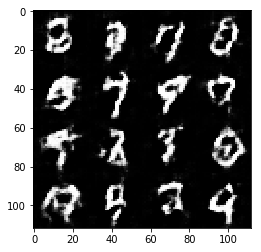

Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 1.1706
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 0.8750
Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 0.9747
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.6726
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.5052
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 0.9145
Epoch 2/2... Discriminator Loss: 1.1401... Generator Loss: 1.0234
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 1.0623


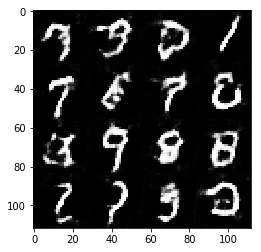

Epoch 2/2... Discriminator Loss: 1.1505... Generator Loss: 0.8707
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.7126
Epoch 2/2... Discriminator Loss: 1.3850... Generator Loss: 0.4567
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.8316
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.6256
Epoch 2/2... Discriminator Loss: 1.3287... Generator Loss: 0.5319
Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 1.0743
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 1.0456


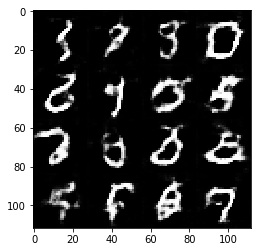

Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 1.0556
Epoch 2/2... Discriminator Loss: 1.2533... Generator Loss: 0.6075
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 0.9549
Epoch 2/2... Discriminator Loss: 1.1418... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 1.2394... Generator Loss: 0.5835
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 0.5807
Epoch 2/2... Discriminator Loss: 1.2152... Generator Loss: 0.7468
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 0.8012
Epoch 2/2... Discriminator Loss: 1.2016... Generator Loss: 0.8016


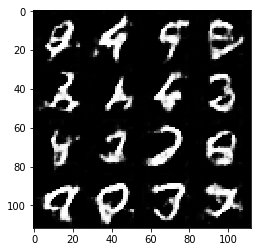

Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 0.8993
Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 0.7281
Epoch 2/2... Discriminator Loss: 1.1880... Generator Loss: 0.9659
Epoch 2/2... Discriminator Loss: 1.2279... Generator Loss: 1.0324
Epoch 2/2... Discriminator Loss: 1.1794... Generator Loss: 0.7066
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 1.1937... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.2775... Generator Loss: 1.1493
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 0.7563
Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.5761


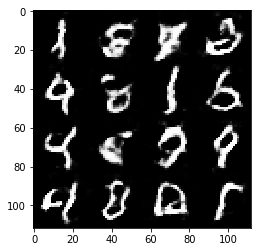

Epoch 2/2... Discriminator Loss: 1.2686... Generator Loss: 0.5908
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 0.6462
Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 1.2390
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 1.1402... Generator Loss: 0.7918
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.7861
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.6451
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 0.6818
Epoch 2/2... Discriminator Loss: 1.3689... Generator Loss: 0.5093
Epoch 2/2... Discriminator Loss: 1.1955... Generator Loss: 1.0423


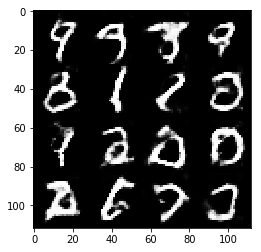

Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.1892... Generator Loss: 0.8158
Done


In [32]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.5208... Generator Loss: 0.1565


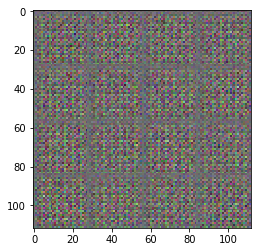

Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.4571
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.2673


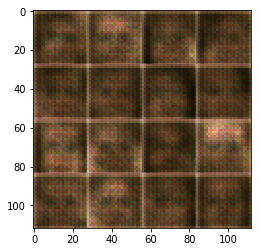

Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 2.0556
Epoch 1/1... Discriminator Loss: 0.4870... Generator Loss: 2.3539
Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 1.8136
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 1.3344
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 1.6610
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 3.1585
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 1.9392


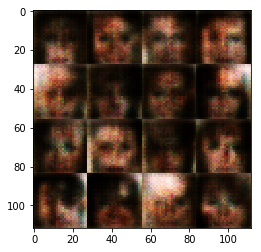

Epoch 1/1... Discriminator Loss: 0.6037... Generator Loss: 1.3609
Epoch 1/1... Discriminator Loss: 0.2979... Generator Loss: 2.4175
Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 0.7025... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 1.4191
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 2.2536
Epoch 1/1... Discriminator Loss: 0.2066... Generator Loss: 5.9714
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 2.3946


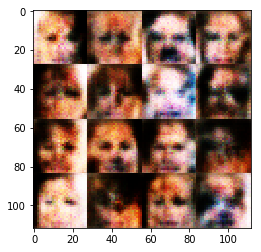

Epoch 1/1... Discriminator Loss: 0.2215... Generator Loss: 2.2582
Epoch 1/1... Discriminator Loss: 0.1146... Generator Loss: 3.7623
Epoch 1/1... Discriminator Loss: 0.1298... Generator Loss: 3.1811
Epoch 1/1... Discriminator Loss: 0.2076... Generator Loss: 6.6631
Epoch 1/1... Discriminator Loss: 0.1077... Generator Loss: 5.7547
Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 6.3801
Epoch 1/1... Discriminator Loss: 0.0877... Generator Loss: 6.2532
Epoch 1/1... Discriminator Loss: 0.0561... Generator Loss: 7.4085
Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 0.9618... Generator Loss: 0.6579


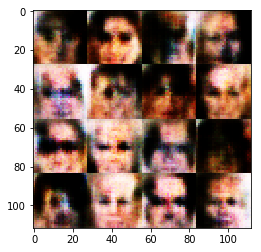

Epoch 1/1... Discriminator Loss: 0.1381... Generator Loss: 6.3263
Epoch 1/1... Discriminator Loss: 0.1172... Generator Loss: 7.6762
Epoch 1/1... Discriminator Loss: 0.0838... Generator Loss: 4.8155
Epoch 1/1... Discriminator Loss: 0.2998... Generator Loss: 2.4493
Epoch 1/1... Discriminator Loss: 0.1894... Generator Loss: 4.8887
Epoch 1/1... Discriminator Loss: 0.3093... Generator Loss: 5.4302
Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 1.6703
Epoch 1/1... Discriminator Loss: 0.5932... Generator Loss: 2.9473
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 7.6547
Epoch 1/1... Discriminator Loss: 0.2282... Generator Loss: 4.1102


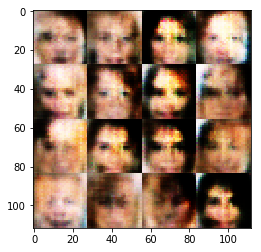

Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.3149
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 5.8115
Epoch 1/1... Discriminator Loss: 0.1685... Generator Loss: 8.1579
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 4.6375
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 2.2254
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 0.2918... Generator Loss: 6.4347
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 5.8382
Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 3.1244
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7350


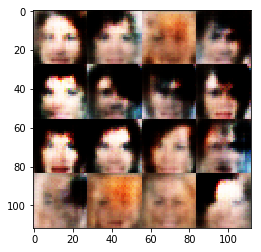

Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 1.5362
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 5.8636
Epoch 1/1... Discriminator Loss: 0.7416... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 0.5024... Generator Loss: 2.3789
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 3.7456
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 2.0892
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 3.0964
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 3.1458
Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 2.5199
Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 2.8175


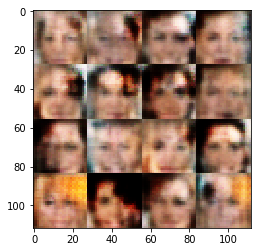

Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 2.4193
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 3.0620
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 1.6015
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.5078
Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 2.6467
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 2.1146
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 3.3253
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 3.0590
Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 1.6422


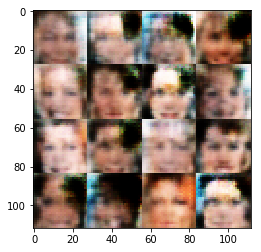

Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 3.1192
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 0.5668... Generator Loss: 1.8394
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 1.8831
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 2.8181
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.3479
Epoch 1/1... Discriminator Loss: 0.6790... Generator Loss: 2.3306
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 2.2232


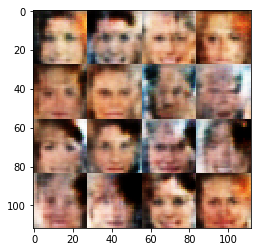

Epoch 1/1... Discriminator Loss: 0.4676... Generator Loss: 2.4815
Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 2.4100
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 2.1166
Epoch 1/1... Discriminator Loss: 0.2048... Generator Loss: 6.3026
Epoch 1/1... Discriminator Loss: 0.6015... Generator Loss: 2.3717
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.5442
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 2.5761
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 2.8932
Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 3.5306
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 2.0794


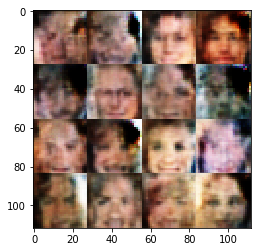

Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 2.5578
Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 2.5821
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 2.4753
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 3.4923
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.5626
Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 3.6130
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 2.1803
Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 3.6565


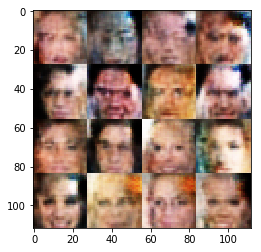

Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 5.5680
Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 1.7377
Epoch 1/1... Discriminator Loss: 0.2237... Generator Loss: 3.9598
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 2.2815
Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 1.2938
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 2.0829
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 2.3151
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 3.4987
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 3.4901
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 2.7751


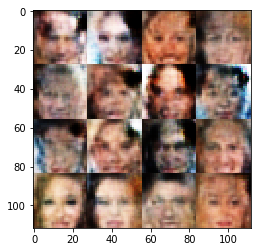

Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.9972
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 1.9507
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 3.2620
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 2.5793
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 1.5275
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.6598
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 2.6597
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.2968


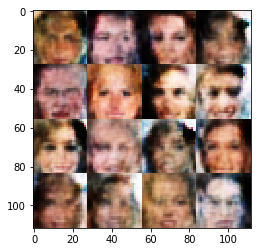

Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 2.3186
Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 2.0496
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 2.0788
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 2.9926
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 6.2352
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 1.9112
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 2.4963
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 3.1087
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 2.8644


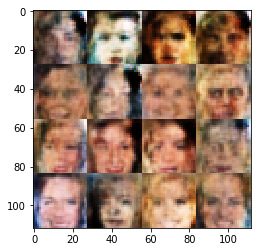

Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.7665
Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 1.4829
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 2.0912
Epoch 1/1... Discriminator Loss: 0.5523... Generator Loss: 3.0579
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.4894
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 2.0774
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 2.0311
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 2.4964


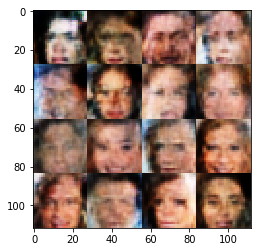

Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 2.1588
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.9454
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 2.4210
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.5556
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.4762
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.5463
Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 2.8867
Done


In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.